## Exploratory Evaluation models (robustness of the models)
Content:
- Training Individuals models WITH Cross validations (in this case repeated Kfolds). Only train with Kfolds and don't do hp tunning


- Compare the robustness of the models across training with different Folds of Data (in each fold is training the same architecture of the model but with different samples of the train dataset, so for example is you use 5folds, 5 models are trained and 5 metrics are saved)


- Make boxplots with the distribution of METRICS of the model getting of the train with different Folds

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
import xgboost
import lightgbm as ltb
from sklearn import datasets, linear_model

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

### -1. Root repo

In [2]:
import os
# get actual path
actual_path = os.path.abspath(os.getcwd())

# divide each folder in the path in a list
# delete the last element to get the root path of the local folder
list_root_path = actual_path.split('\\')[:-1]

# join the list in a string with the root
root_path = '\\'.join(list_root_path)

# pararme en el root obtenido
os.chdir(root_path)

print('before: ', actual_path)
print('after: ', root_path)

before:  D:\Github-mi-repo\Discovery-ensembles-stackings-methods\discovery
after:  D:\Github-mi-repo\Discovery-ensembles-stackings-methods


###  0. Parameters

In [3]:
# parameters to dataset
path_data_folder = 'data'
path_data_example_1 = 'example1'

### 1. Load data

In [5]:
# load data
def load_data(path_data):
    '''
    Given the path of the folder where are located the data, load it.
    OBS: the data must to be a csv file and separed into X_train, y_train, X_test, y_test
    '''
    
    X_train = pd.read_csv(path_data + '/' + 'X_train.csv', index_col = 0)
    y_train = pd.read_csv(path_data + '/' + 'y_train.csv', index_col = 0)

    X_test = pd.read_csv(path_data + '/' + 'X_test.csv', index_col = 0)
    y_test = pd.read_csv(path_data + '/' + 'y_test.csv', index_col = 0)

    print('X_train: ', X_train.shape)
    print('y_train: ', y_train.shape)
    print('X_test: ', X_test.shape)
    print('y_test: ', y_test.shape)
    
    return X_train, y_train, X_test, y_test

In [6]:
# path
path_data = path_data_folder + '/' + path_data_example_1

# load data
X_train, y_train, X_test, y_test = load_data(path_data)

X_train:  (800, 20)
y_train:  (800, 1)
X_test:  (200, 20)
y_test:  (200, 1)


### 2. Create models (sklearn)
- Create a function that have all the models that will train with different Folds
- Models without changes in its parameters (NO hp tunning)

- To train with CV it's necessary create a CV SPLITTER and after that call the function cross_val_score to train the model with the differents folds defined in the splitter and return the metric getting of each different folds

In [7]:
def get_models():
    '''
    Create a function that have ALL THE MODELS THAT WILL trained
    '''
    # create a dictionary where are saved the different models that will be trained
    models = dict()

    # complete dictionary with models
    models['lr'] = LinearRegression()
    models['cart'] = DecisionTreeRegressor(random_state = 42)
    models['rf'] = RandomForestRegressor(random_state = 42)
    models['knn'] = KNeighborsRegressor()
    models['svr'] = SVR()
    models['xgb'] = xgboost.XGBRegressor(random_state = 42)
    models['ltb'] = ltb.LGBMRegressor(random_state = 42)
    
    # return dictionary with the models
    return models

In [8]:
# get models
models = get_models()

### 3.- Evaluate quality of the models (cross validation)
- Evaluate the distributions of the METRICS of each model using repeated cross validation

In [9]:
def evaluate_model(model, X, y):
    '''
    Given a model and a dataset train (X, y).
    Generate the splitter and then train the model with the differents folds and return the metrics getting in 
    the training of each folder
    '''
    # defining a CV SPLITTER (repeated K folds)
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
    
    # getting the scores for each FOLD
    scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv)
    scores = -scores
    
    return scores

### 4.- Run the evaluation of the models

In [10]:
def evaluate_quality_of_models(X, y, dicc_models):
    '''
    Evaluate the quality of the models
    
    Given the dataframe of Train and a dictionary with all the models that will be evaluated using repated cross validation
    '''
    
    # initialize
    results_metrics_model, name_model = [], []


    # run
    for name, model in dicc_models.items():
        print('\nEvaluating... ', name)

        # get metrics of each model
        scores = evaluate_model(model, X, y)
        results_metrics_model.append(scores)
        name_model.append(name)

        #print
        print(f'Mean: {round(np.mean(scores), 3)} // std: {round(np.std(scores), 3)}')
        
    
    return results_metrics_model, name_model

In [11]:
results_metrics_model, name_model = evaluate_quality_of_models(X = X_train, 
                                                               y = y_train, 
                                                               dicc_models = models)


Evaluating...  lr
Mean: 0.106 // std: 0.008

Evaluating...  cart
Mean: 191.668 // std: 15.173

Evaluating...  rf
Mean: 117.237 // std: 7.87

Evaluating...  knn
Mean: 130.761 // std: 9.204

Evaluating...  svr
Mean: 203.521 // std: 14.149

Evaluating...  xgb
Mean: 103.723 // std: 7.738

Evaluating...  ltb
Mean: 80.177 // std: 7.268


### 5. Make boxplot with the distribution of the metrics of each model

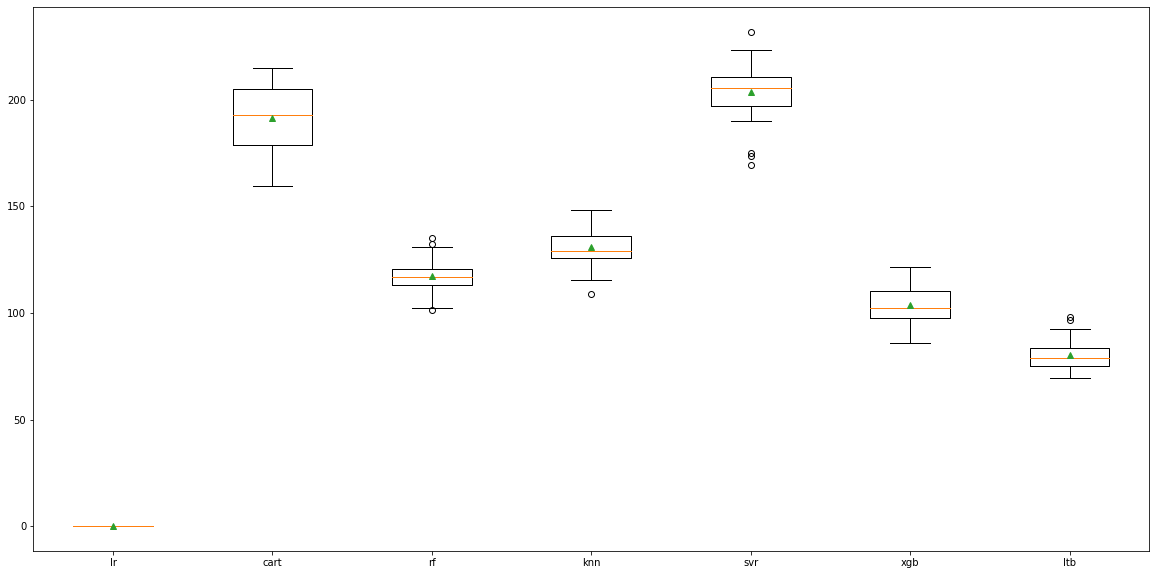

In [12]:
plt.figure(figsize = (20, 10))
plt.boxplot(results_metrics_model, labels = name_model, showmeans=True)
plt.show()